# Steady-state analysis



In [1]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)


## Set up the environment

RESET


<IPython.core.display.Javascript object>


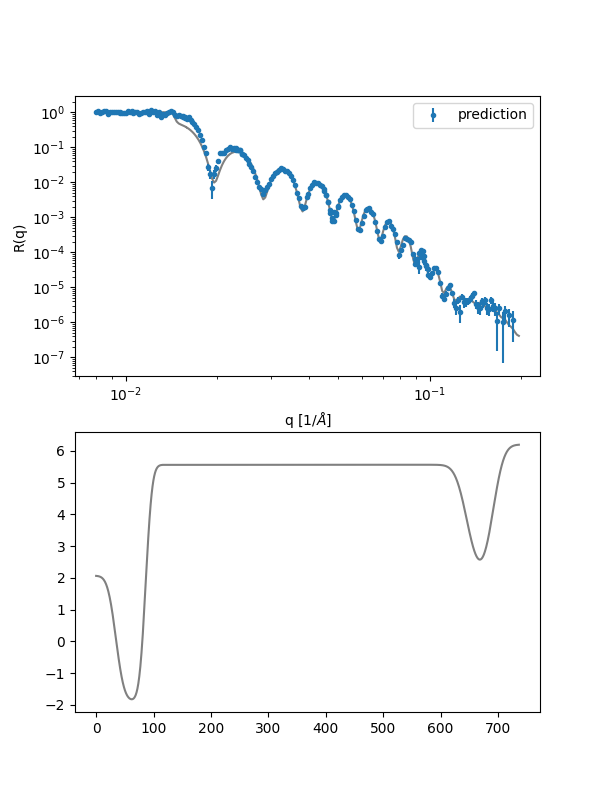

In [74]:
import steady_state
importlib.reload(steady_state)

# OCV 1
data_file = os.path.join(git_dir, 'data', 'REFL_207268_combined_data_auto.txt')

# OCV 2
data_file = os.path.join(git_dir, 'data', 'REFL_207282_combined_data_auto.txt')

_data = np.loadtxt(data_file).T
_data[1] = _data[1]/1.06

# Initial state is entered as a list of layers.
# First layer is the incoming medium.
# Layer parameter [0:thickness, 1:interface, 2:rho, 3:irho]

initial_state = [[0, 15, 6.2, 0],
                 [50, 10, 3, 0],
                 [550, 10, 6.7, 0],
                 [50, 10, -2, 0],
                 [0, 0, 2.07, 0]
                ]

  
# create an instance of our custom environment
env = steady_state.AnalyzerEnv(initial_state=initial_state,
                               data=_data, engine='amoeba')

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
print("RESET")
env.reset()
env.plot(errors=True)


## View the initial time and check that the initial model makes sense

ACTION
 - Inserting layer at index 1 with parameters 0.06189168=[0.24844535 0.005      0.6        0.        ]

Current parameters:
Layer 0: 0	15	6.2	0
Layer 1: 152.833	3.41023	5.38302	0
Layer 2: 33.1912	3.48408	1.03682	0
Layer 3: 567.183	1.79861	6.38968	0
Layer 4: 52.1223	1.84614	-1.16948	0
Layer 5: 0	0	2.07	0

reward: -1.8651816681483417
chi2: 1.86518
[0.9532451  0.1        0.06189168 0.24844535]


<IPython.core.display.Javascript object>


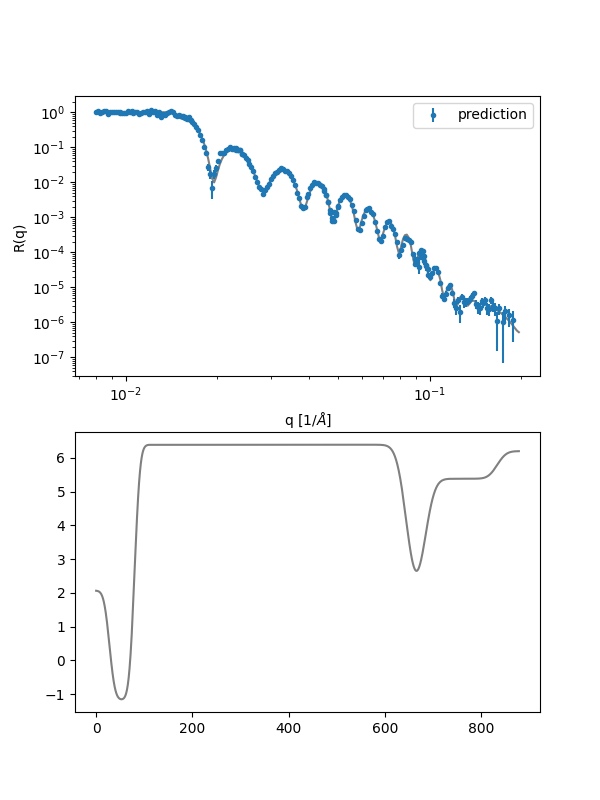

In [70]:
# choose a random action or use our initial fit
env.reset()
action = env.action_space.sample()

# Inserting layers
action = np.asarray([0.9532451,  .10, 0.06189168,  0.24844535])

# Changing layer param
#action = np.asarray([0.5,  .5, 0.4,  0.24844535])

# Deleting layer
#action = np.asarray([0.,  0., 0,  0.24844535])

print("ACTION")
# take the action and get the information from the environment
new_state, reward, terminated, truncated, info = env.step(action, True)
#new_state, reward, terminated, truncated, info = env.step(action)
#new_state, reward, terminated, truncated, info = env.step(action)
#new_state, reward, terminated, truncated, info = env.step(action)
print("reward: %s" % reward)
print("chi2: %g" % env.chi2)

# show the current position and reward
env.render(action=action, reward=reward) 


env.plot(errors=True)

## Train or load model

In [75]:
%%time

from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path="./logs-v3/",
    name_prefix="steady-state",
    save_replay_buffer=False,
    save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)

if True:
    model.learn(2000)
    #model.learn(80000, callback=checkpoint_callback)
    model.save('steady-state-v3')
else:
    model = SAC.load('steady-state-v3')

CPU times: user 25min 1s, sys: 28min 52s, total: 53min 53s
Wall time: 10min 48s


## Run the agent on the time series data

In [ ]:
# Evaluate the agent

obs, info = env.reset()
env.reward_cutoff = 1
env.engine = 'amoeba'
env.engine = 'dream'
print("Starting chi2: %g" % env.chi2_0)
chi2 = []
for i in range(4):
    action, _ = model.predict(obs, deterministic=True)
    #print(action)
    chi2.append(env.chi2)
    new_obs, reward, terminated, truncated, info = env.step(action, False)  
    print("%d: %g %g %g [%s]\n" % (i, reward, env.chi2, env.state[0], terminated))
    if truncated:
        env.reset()
    else:
        obs = new_obs

    if terminated:
        break



env.plot()

# Compute uncertainties

In [316]:
# There's likely a way to dig into the SAC parameters and fish out the action standard deviations

deltas = env.high_array - env.low_array

samples = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)


samples = np.asarray(samples).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

AttributeError: 'AnalyzerEnv' object has no attribute 'high_array'

## Plot the results and compare to the Bayesian approach

# Training progression

<IPython.core.display.Javascript object>


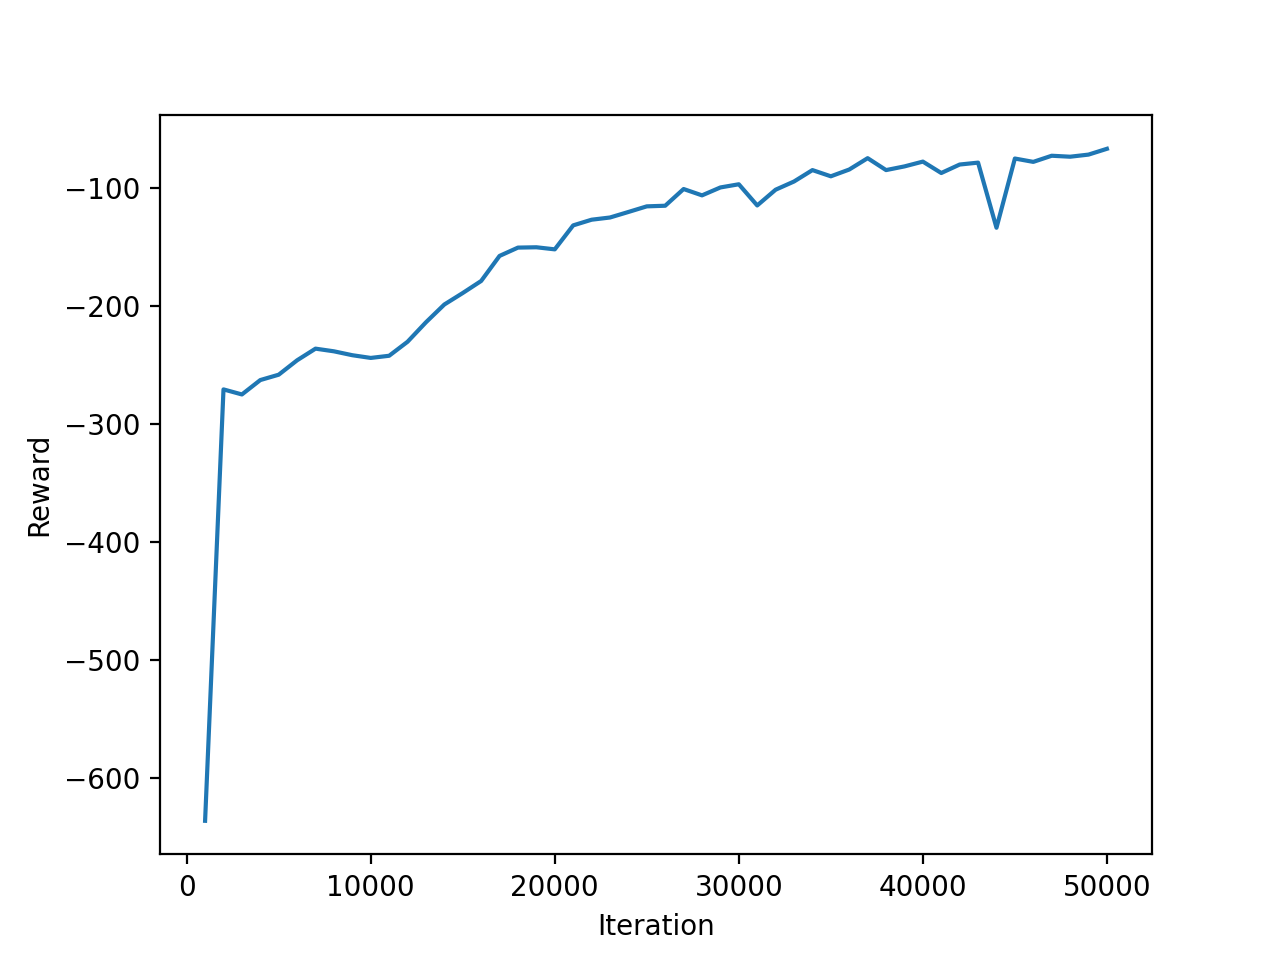

In [10]:
log_dir = "./logs-forward-no-final-state/"
log_dir = "./logs-06-to-01-fwd/"
_dir_list = os.listdir(log_dir)

def evaluate(model):
    episode_reward = 0
    n_times = len(env.data)
    obs, info = env.reset()

    chi2 = 0
    for i in range(n_times):
        action, _ = model.predict(obs, deterministic=True)
        chi2 += env.chi2
        obs, reward, terminated, truncated, info = env.step(action)  
        episode_reward += reward
    return episode_reward

itr_list = []
reward_list = []

for file in _dir_list:
    model = SAC.load(os.path.join(log_dir, file))
    reward = evaluate(model)
    iteration = int(file.replace("rl_model-forward_", "").replace("_steps.zip", ""))
    itr_list.append(iteration)
    reward_list.append(reward)

itr_list = np.asarray(itr_list)
reward_list = np.asarray(reward_list)
idx = itr_list.argsort()

fig = plt.figure(dpi=100)
plt.plot(itr_list[idx], reward_list[idx])
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.show()
        